# Analyze network balance with frustration index an algebraic conflict

In [1]:
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
import tqdm
import os
from tqdm import tqdm
import glob
import re

import sys
sys.path.append('../local/bin/')

from sygno.signed_networkx import draw_signed_networkx

____________________

In [2]:
dataset_folder = '../dataset/'

Load the dataframe created in the *data_parsing.ipynb* containing all the information about the members of the congresses

In [3]:
pol = pd.read_csv(dataset_folder + 'members.csv')
pol['color'] = pol['party_name'].apply(lambda x: 'firebrick' if 'Republican' in x else ('royalblue' if 'Democrat' in x else 'yellow'))
pol.head()

,icpsr,congress,party_code,bioname,state_abbrev,party_name,color
0,1,[82],[200],"AANDAHL, Fred George",ND,['Republican'],firebrick
1,2,"[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 9...",[100],"ABBITT, Watkins Moorman",VA,['Democrat'],royalblue
2,3,"[28, 29, 30]",[29],"ABBOTT, Amos",MA,['Whig'],yellow
3,4,"[50, 51, 52, 53, 54]",[100],"ABBOTT, Jo (Joseph)",TX,['Democrat'],royalblue
4,5,"[15, 16, 17, 18]","[7777, 13]","ABBOT, Joel",GA,"['Crawford Republican', 'Democrat-Republican']",firebrick


Create a dictionary that links each icpsr to a party. Notice that an icpsr identifies uniquely a legislator, but a legislator can have more than one icpsr. This is because the icpsr is assigned to a legislator for each congress. For example, if a legislator is elected in 2000 and reelected in 2002, he will have two different icpsr, one for each congress. We will use the icpsr of the first congress in which the legislator was elected.

In [4]:
pol_dic = pol[['icpsr', 'party_name']].set_index('icpsr').to_dict(orient="index")
# e.g.
pol_dic[323]

{'party_name': "['Democrat-Republican']"}

In [5]:
def draw_graph(df, pol_dic):

    # Arguments:
	# df ---> edgelist
	# pol_dic ---> dictionary where key is icpsr and value is party_name
	# congress_num ---> congress number

    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'])

    nodeData = {list(g.icpsr)[0]: {'state': list(g.state_abbrev)[0], 'party': list(g.party_name)[0], 'color': list(g.color)[0],  'congress': list(g.congress)[0], 'name': list(g.bioname)[0]} for k, g in pol.groupby('icpsr')}
    nx.set_node_attributes(G, nodeData)

    colors = [node[1]['color'] for node in G.nodes(data=True)]
    
    fig, ax, pos, least_eigenvalue = draw_signed_networkx(G, node_color=colors, compact = True, theme="white", normalize=True, scale='log', jittering=0.01, margin=0.2, show_rotation=False, highlight_edges='frustrated', remove_n_outliers=3, sort_by='party')
    
    # print infos about users per party
    positions_party = {'pos': {'Democrat': 0,'Republican':0}, 'neg': {'Democrat': 0,'Republican':0}}
    for p in pos.keys():
        if pos[p].x > 0:
            if pol_dic[int(p)]['party_name'] == 'Democrat' or pol_dic[int(p)]['party_name'] == 'Republican':
                positions_party['pos'][pol_dic[int(p)]['party_name']] += 1
        else:
            if pol_dic[int(p)]['party_name'] == 'party_name' or pol_dic[int(p)]['party_name'] == 'Republican':
                positions_party['neg'][pol_dic[int(p)]['party_name']] += 1

    plt.text(0, .04, "Rep: "+str(positions_party['neg']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0, .09, "Dem: "+str(positions_party['neg']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")

    plt.text(0.9, .04, "Rep: "+str(positions_party['pos']['Republican']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    plt.text(0.9, .09, "Dem: "+str(positions_party['pos']['Democrat']), fontsize=13, transform=ax.transAxes, color="ghostwhite")
    

    plt.show()

    return least_eigenvalue

In [6]:
def read_edgelist(folder, threshold_pos, threshold_neg):
    # read edgelist
    df = pd.read_csv(folder)
    df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
    df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
    df = pd.concat([df_pos, df_neg])
    

    least_eigen = draw_graph(df, pol_dic)

    return least_eigen

In [7]:
thresholds_path = '../dataset/thresholds/'
edgelists_path = '../dataset/edgelists/'

_______________________________________________________________

## Compute the Algebraic Conflict
##### i.e. the smallest eigenvalue of the (signed) Laplacian matrix

In [13]:
from sygno.nodes_position import _get_xcoord

In [14]:
def compute_eigen(df):
    def compute_d_max(G):
        max_d = 0
        for edge in G.edges(data=True):
            temp = G.degree[edge[0]] + G.degree[edge[1]]
            if temp > max_d:
                max_d = temp
        return max_d / 2

    G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight'])
    df, least_eigenvalue = _get_xcoord(G, compact=False)
    max_d = compute_d_max(G)
    eig = 1-(least_eigenvalue/(max_d-1))
    return eig

In [16]:
def read_edgelist_eigen(folder, threshold_pos, threshold_neg):
    # read edgelist
    df = pd.read_csv(folder)
    df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
    df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
    df = pd.concat([df_pos, df_neg])

    return compute_eigen(df)

In [17]:
# for every clausen category, define a dictionary with the congress as key and the eigenvalue as value
eigenvalues = {}

100%|██████████| 37/37 [00:27<00:00,  1.36it/s]


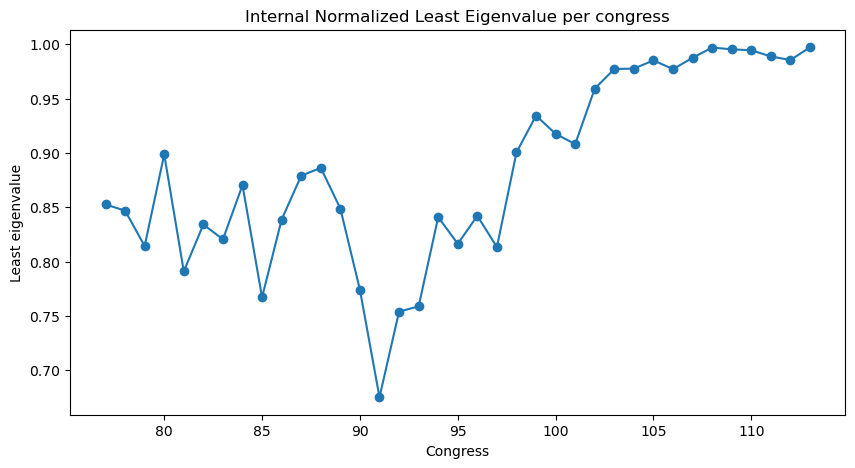

In [20]:
for csv in tqdm(glob.glob(edgelists_path + 'votes_house_peltzman_edges/' + 'Internal' + '/*.csv')):
	n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))

	#check if the threshold file exists, otherwise continue
	if not os.path.exists(thresholds_path + 'house_peltzman_thresholds/' + 'Internal' + '/' + str(n_congress) + '_dic_thresholds_norm.csv'):
		continue

	# Rest of your existing code to compute eigenvalues
	temp = pd.read_csv(thresholds_path + 'house_peltzman_thresholds/' + 'Internal' + '/' + str(n_congress) + '_dic_thresholds_norm.csv')
	threshold_pos = temp.iloc[0]['pos_threshold']
	threshold_neg = temp.iloc[0]['neg_threshold']

	# Read the CSV file into a pandas DataFrame
	df = pd.read_csv(csv)
	df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
	df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
	df = pd.concat([df_pos, df_neg])

	# Create a graph from the DataFrame
	G = nx.from_pandas_edgelist(df, 'source', 'target')

	# check if df is empty
	if df.empty:
		continue
	else:
		# Check if the graph is connected
		if not nx.is_connected(G):
		# If the graph is not connected, continue to the next iteration
			continue

	least_eigevalue = read_edgelist_eigen(csv, threshold_pos, threshold_neg)
	eigenvalues[n_congress] = least_eigevalue

	#plot the eigenvalues sorted by congress
	
plt.figure(figsize=(10, 5))
plt.plot(sorted(eigenvalues.keys()), [eigenvalues[x] for x in sorted(eigenvalues.keys())], 'o-')
plt.xlabel('Congress')
plt.ylabel('Least eigenvalue')
plt.title(str('Internal') + ' Normalized Least Eigenvalue per congress')
plt.savefig('../plots/norm_least_eigenvalues/house_clausen/' + str('Internal') + '_nle.png')

plt.show()

In [21]:
eigenvalues = {}

100%|██████████| 37/37 [00:26<00:00,  1.42it/s]


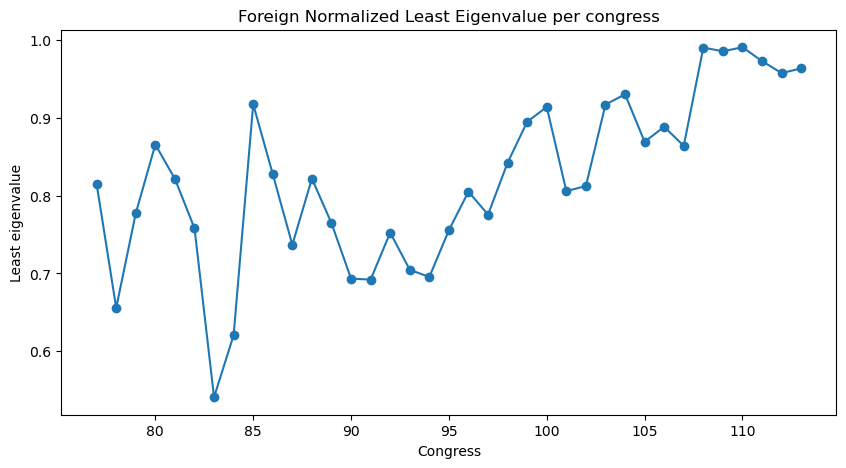

In [23]:
for csv in tqdm(glob.glob(edgelists_path + 'votes_house_peltzman_edges/' + 'Foreign' + '/*.csv')):
		n_congress = int(os.path.basename(csv).replace('congress_', '').replace('.csv', ''))

		#check if the threshold file exists, otherwise continue
		if not os.path.exists(thresholds_path + 'house_peltzman_thresholds/' + 'Foreign' + '/' + str(n_congress) + '_dic_thresholds_norm.csv'):
			continue

		# Rest of your existing code to compute eigenvalues
		temp = pd.read_csv(thresholds_path + 'house_peltzman_thresholds/' + 'Foreign' + '/' + str(n_congress) + '_dic_thresholds_norm.csv')
		threshold_pos = temp.iloc[0]['pos_threshold']
		threshold_neg = temp.iloc[0]['neg_threshold']

		# Read the CSV file into a pandas DataFrame
		df = pd.read_csv(csv)
		df_pos = df.loc[(df['weight']==1)&(df['perc']>threshold_pos)].copy()
		df_neg = df.loc[(df['weight']==-1)&(df['perc']>threshold_neg)].copy()
		df = pd.concat([df_pos, df_neg])

		# Create a graph from the DataFrame
		G = nx.from_pandas_edgelist(df, 'source', 'target')

		# check if df is empty
		if df.empty:
			continue
		else:
			# Check if the graph is connected
			if not nx.is_connected(G):
			# If the graph is not connected, continue to the next iteration
				continue

		least_eigevalue = read_edgelist_eigen(csv, threshold_pos, threshold_neg)
		eigenvalues[n_congress] = least_eigevalue

		#plot the eigenvalues sorted by congress
	
plt.figure(figsize=(10, 5))
plt.plot(sorted(eigenvalues.keys()), [eigenvalues[x] for x in sorted(eigenvalues.keys())], 'o-')
plt.xlabel('Congress')
plt.ylabel('Least eigenvalue')
plt.title('Foreign' + ' Normalized Least Eigenvalue per congress')
plt.savefig('../plots/norm_least_eigenvalues/house_peltzman/' + 'Foreign' + '_nle.png')

plt.show()